# Модель 19
### `GrigaNet V4`

#### Импорт необходимых библиотек

In [1]:
import sys

import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import torchvision as tv
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from livelossplot import PlotLossesKeras

sys.path.append('../../')

from core.datasets import get_ds
from core.make_answer import make_ans_file

c:\Users\Mi\Desktop\ML\.conda\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
num_model = '_g_18'

#### Аугментация (4)

In [3]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-10, 10), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

#### Скачиваем датасеты

In [4]:
train_ds, val_ds, test_ds = get_ds(
    'smote_data_train_7000', 'repaired_data_test', val_size=0.12,
    transform=transformer, one_hot=True, back=2, batch_size=100
)

Для дальнейшей проверки метрик разделяем валидационный датасет на x и y

In [5]:
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])

Смотрим на получившуюся агументацию.

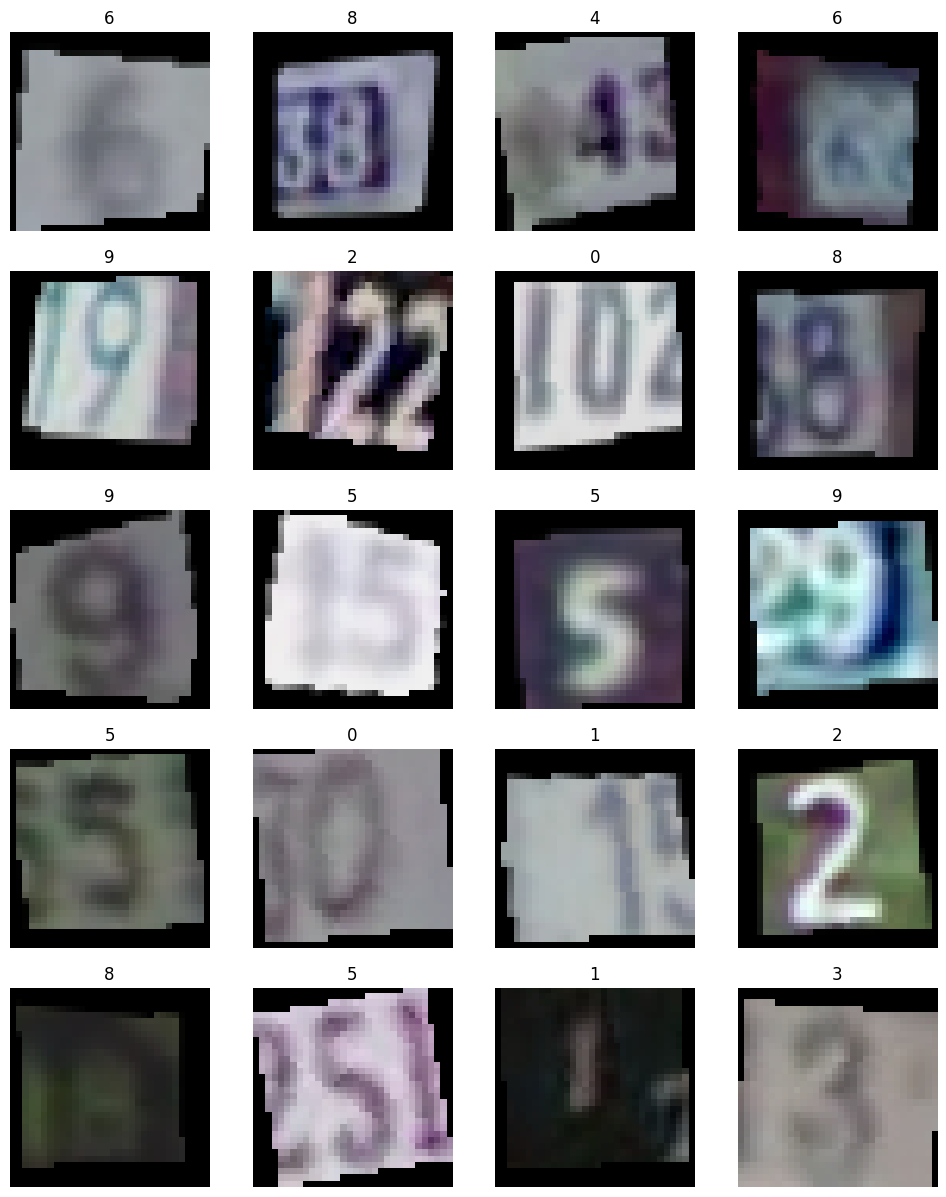

In [6]:
plt.figure(figsize=(12, 15))
train_ds_visualization = train_ds[0]
for i in range(20):
    plt.subplot(5, 4, i + 1)
    img = np.array(Image.fromarray((train_ds_visualization[0][i] * 255).astype(np.uint8), 'RGB'))
    plt.imshow(img / 255, cmap=plt.cm.binary)
    plt.title(np.argmax(train_ds_visualization[1][i]))
    plt.axis('off')
plt.show()

#### Пишем модель

Мылси о моделе: 
- Постараюсь написать просто максимально упрощеный resnet

In [7]:
# import tensorflow as tf
inputs = tf.keras.layers.Input(shape=(32, 32, 3), batch_size=100)

block1 = tf.keras.layers.Conv2D(32, 3)(inputs)
x = tf.keras.layers.Conv2D(32, 3, padding='same')(block1)
x = tf.keras.layers.Conv2D(32, 3, padding='same')(x)
add = tf.keras.layers.add([block1, x])

block2 = tf.keras.layers.MaxPool2D()(add)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(block2)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
block2 = tf.keras.layers.Conv2D(64, 3, padding='same')(block2)
add = tf.keras.layers.add([block2, x])

block3 = tf.keras.layers.MaxPool2D()(add)
x = tf.keras.layers.Conv2D(128, 3, padding='same')(block3)
x = tf.keras.layers.Conv2D(128, 3, padding='same')(x)
block3 = tf.keras.layers.Conv2D(128, 3, padding='same')(block3)
add = tf.keras.layers.add([block3, x])

x = tf.keras.layers.Flatten()(add)
outputs = tf.keras.layers.Dense(10)(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(100, 32, 32, 3)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (100, 30, 30, 32)    896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (100, 30, 30, 32)    9248        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (100, 30, 30, 32)    9248        ['conv2d_1[0][0]']               
                                                                                              

#### Создаем чекпоинты

In [8]:
metrics = ['categorical_accuracy',
           tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')]
callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    ),

    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    )
]

#### Компиляция модели

In [9]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * tf.math.exp(-0.03)


callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))

In [10]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam(0.002)),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

#### Обучаем модель

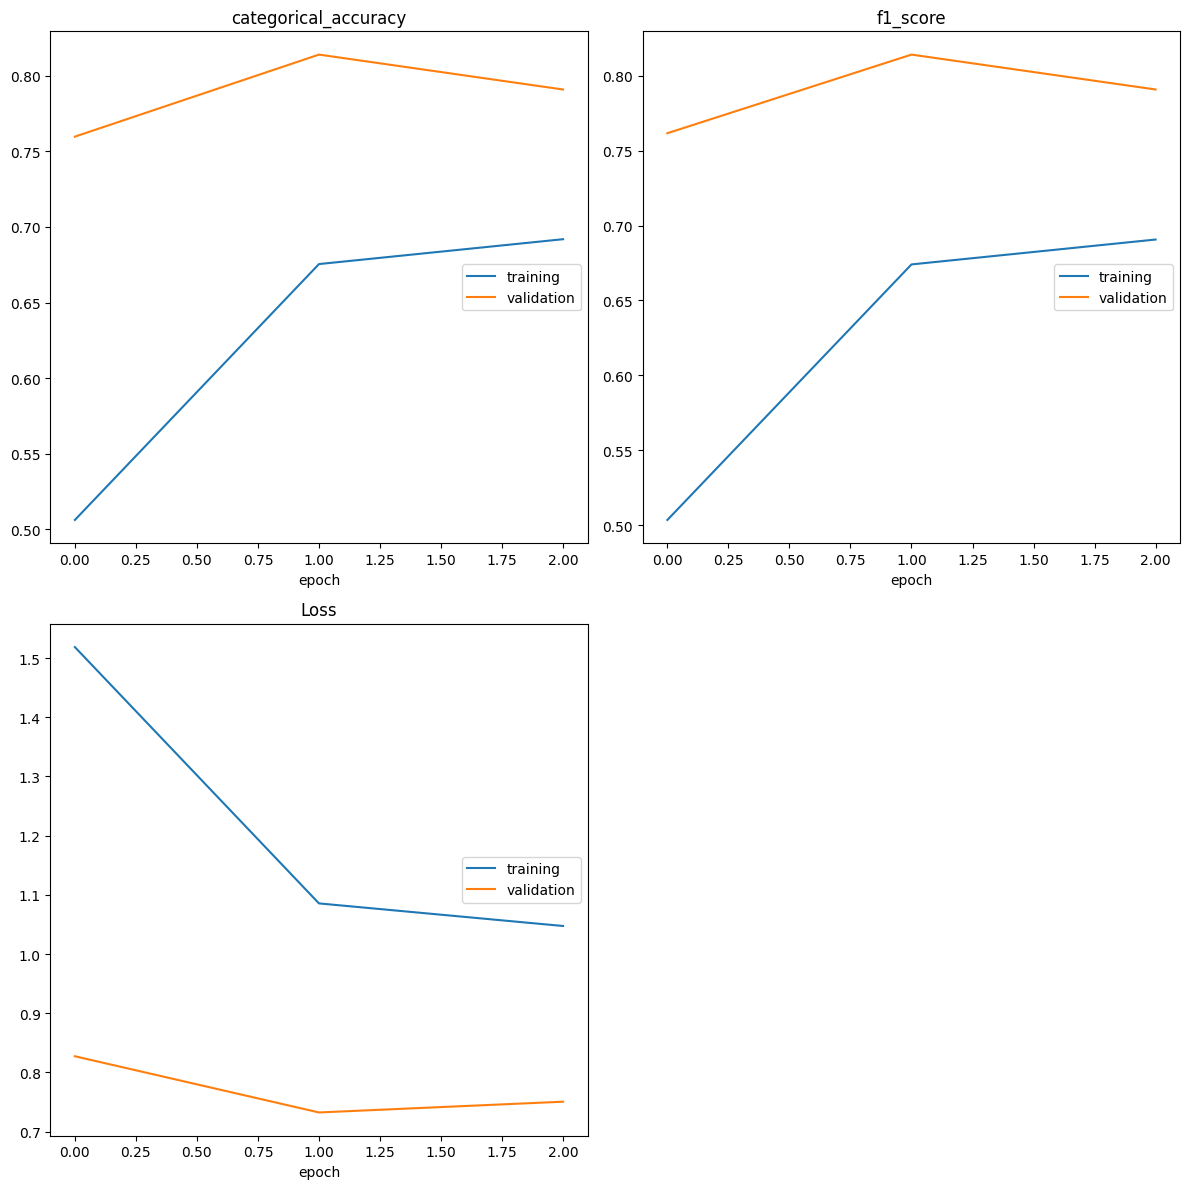

categorical_accuracy
	training         	 (min:    0.506, max:    0.692, cur:    0.692)
	validation       	 (min:    0.760, max:    0.814, cur:    0.791)
f1_score
	training         	 (min:    0.504, max:    0.691, cur:    0.691)
	validation       	 (min:    0.762, max:    0.814, cur:    0.791)
Loss
	training         	 (min:    1.047, max:    1.518, cur:    1.047)
	validation       	 (min:    0.732, max:    0.827, cur:    0.751)
616/616 [==============================] - 868s 1s/step - loss: 1.0474 - categorical_accuracy: 0.6919 - f1_score: 0.6907 - val_loss: 0.7506 - val_categorical_accuracy: 0.7910 - val_f1_score: 0.7908 - lr: 0.0020
Epoch 4/100
 68/616 [==>...........................] - ETA: 14:26 - loss: 1.0202 - categorical_accuracy: 0.6954 - f1_score: 0.6938

In [11]:
model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)

Подгружаем все чекпоинты

In [ ]:
model_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_categorical_accuracy.h5')
model_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_f1_score.h5')
model_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_loss.h5')
model_avg_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5')
model_avg_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_f1_score.h5')
model_avg_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_loss.h5')

У нас поличилось шесть чекпоинта (шесть моделей). Ниже указан код для получения ответов для всех чекпоинтов по валидационному датасету.

In [ ]:
ans_val_categorical_accuracy = make_ans_file(model_categorical_acc, val_ds_x)
ans_val_f1_score = make_ans_file(model_f1_score, val_ds_x)
ans_val_loss = make_ans_file(model_loss, val_ds_x)
ans_val_avg_categorical_accuracy = make_ans_file(model_avg_categorical_acc, val_ds_x)
ans_val_avg_f1_score = make_ans_file(model_avg_f1_score, val_ds_x)
ans_val_avg_loss = make_ans_file(model_avg_loss, val_ds_x)
anss = [ans_val_categorical_accuracy, ans_val_f1_score, ans_val_loss, ans_val_avg_categorical_accuracy, ans_val_avg_f1_score, ans_val_avg_loss]

Формируем валидационные ответы.

In [ ]:
val_ds_y = np.argmax(val_ds_y, axis=1)

Сравниваем валидационные предикты каждого чекпоинта

In [ ]:
for i in range(len(anss) - 1):
    for j in range(i + 1, len(anss)):
        if np.all(anss[i] == anss[j]):
            print(f'чекпоинты {i + 1} и {j + 1} одинаковые')

чекпоинты 1 и 2 одинаковые
чекпоинты 4 и 5 одинаковые


Рассмотрим только 1, 3, 4, 6

## ВЫВОД:

In [ ]:
class MulticlassClassificationMetrics:
    def __init__(self, y_true, y_pred):
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.matrix_error = self.get_matrix_error()

    def get_matrix_error(self):
        self.class_types = np.unique([self.y_true, self.y_pred])
        TP, FN, FP, TN = [], [], [], []
        for class_type in self.class_types:
            TP.append(np.sum(np.logical_and(self.y_true == self.y_pred, self.y_true == class_type)))
            FN.append(np.sum(np.logical_and(self.y_true == class_type, self.y_pred != class_type)))
            FP.append(np.sum(np.logical_and(self.y_pred == class_type, self.y_true != class_type)))
            TN.append(np.sum(np.logical_and(self.y_pred != class_type, self.y_true != class_type)))
        return pd.DataFrame({
            'class_type': self.class_types,
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        }).set_index('class_type')

    def accuracy(self):
        return np.sum(self.y_true == self.y_pred) / self.y_true.shape[0]

    def precision(self, averaging='macro'):
        if averaging == 'macro':
            precisions = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FP'])
            return np.mean(precisions.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FP'])

    def recall(self, averaging='macro'):
        if averaging == 'macro':
            recalls = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FN'])
            return np.mean(recalls.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FN'])

    def f1_score(self, averaging='macro'):
        if averaging == 'macro':
            reverse_r = (self.matrix_error['TP'] + self.matrix_error['FN']) / self.matrix_error['TP']
            reverse_p = (self.matrix_error['TP'] + self.matrix_error['FP']) / self.matrix_error['TP']
            f1_scores = 2 / (reverse_r + reverse_p)
            return np.mean(f1_scores.replace(np.nan, 0))
        elif averaging == 'micro':
            p = self.precision(averaging)
            r = self.recall(averaging)
            return 2 * p * r / (p + r)

    def metrics(self, averaging='macro'):
        return {
            'accuracy': self.accuracy(),
            'precision': self.precision(averaging),
            'recall': self.recall(averaging),
            'f1_score': self.f1_score(averaging),
        }

    def __str__(self):
        headers = {
            'selector': '*',
            'props': 'background-color: darkgreen; color: white; font-size: 12pt;',
        }
        che_super_mega_puper_visualization_of_cell = { 
            'selector': 'td:hover',
            'props': 'background-color: green; color: white;',
        }
        display(
            self.matrix_error
            .style
            .set_table_styles([
                headers,
                che_super_mega_puper_visualization_of_cell,
            ])
            .set_properties(**{'background-color': 'lightgreen',
                           'color': 'black', 'font-size': '12pt'})
        )
        return ''

    def __repr__(self):
        return (
            f'MulticlassClassificationMetrics(class_types={self.class_types})'
            .replace("'", '').replace(',', ';'))

### Accuracy чекпоинт

In [ ]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,229,3259,6,7
1,624,2835,25,17
2,548,2921,10,22
3,401,3068,12,20
4,346,3142,5,8
5,301,3174,17,9
6,259,3217,12,13
7,254,3225,17,5
8,229,3249,10,13


{'accuracy': 0.9654384461582405,
 'precision': 0.9636699953096717,
 'recall': 0.9649551933686222,
 'f1_score': 0.964218063898084}

## F1-score чекпоинт

In [ ]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,231,3259,6,5
1,619,2846,14,22
2,561,2911,20,9
3,401,3072,8,20
4,344,3139,8,10
5,303,3164,27,7
6,258,3226,3,14
7,250,3234,8,9
8,233,3252,7,9


{'accuracy': 0.9680091402456441,
 'precision': 0.9667369204528764,
 'recall': 0.9671243550465475,
 'f1_score': 0.9667509044420168}

## Скользящее среднее по accuracy чекпоинт

In [ ]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,234,3260,5,2
1,634,2842,18,7
2,555,2922,9,15
3,403,3071,9,18
4,349,3142,5,5
5,304,3179,12,6
6,262,3223,6,10
7,254,3235,7,5
8,231,3251,8,11


{'accuracy': 0.9757212225078549,
 'precision': 0.974827802029408,
 'recall': 0.974591820498474,
 'f1_score': 0.9746653166919812}

### Скользящее среднее по F1-score чекпоинт.

In [ ]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,233,3260,5,3
1,632,2848,12,9
2,560,2918,13,10
3,401,3069,11,20
4,346,3140,7,8
5,300,3182,9,10
6,264,3224,5,8
7,256,3237,5,3
8,235,3251,8,7


{'accuracy': 0.9762924878606113,
 'precision': 0.9751147911701767,
 'recall': 0.975791024130149,
 'f1_score': 0.9754278085895749}

Метрики неплохие

- Сохраняем ответы.

In [ ]:
ans_test_categorical_accuracy = make_ans_file(model_categorical_acc, test_ds, f'../answers/model{num_model}_categorical_accuracy.csv')
ans_test_f1_score = make_ans_file(model_f1_score, test_ds, f'../answers/model{num_model}_f1_score.csv')
ans_test_loss = make_ans_file(model_loss, test_ds, f'../answers/model{num_model}_loss.csv')
ans_test_avg_categorical_accuracy = make_ans_file(model_avg_categorical_acc, test_ds, f'../answers/model{num_model}_avg_categorical_accuracy.csv')
ans_test_avg_f1_score = make_ans_file(model_avg_f1_score, test_ds, f'../answers/model{num_model}_avg_f1_score.csv')
ans_test_avg_loss = make_ans_file(model_avg_loss, test_ds, f'../answers/model{num_model}_avg_loss.csv')
anss = [ans_test_categorical_accuracy, ans_test_loss, ans_test_avg_categorical_accuracy, ans_test_avg_loss]

Проверяем ответы (одинаковые они или нет), чтоб не терять кол-во отправок ответов на kaggle в день.

In [ ]:
for i in range(len(anss) - 1):
    for j in range(i + 1, len(anss)):
        if np.all(anss[i] == anss[j]):
            print(f'чекпоинты {i + 1} и {j + 1} одинаковые')

Все ответы разные, поэтому отправляем все на kaggle `categorical_accuracy`, `loss`, `avg_categorical_accuracy`, `avg_loss` чекпоинты